In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np
factorial = np.math.factorial

import matplotlib.pyplot as plt

# custom module where all models are written
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator # model
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_samples # sample generator
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_isoprob_transform # isoprobabilistic transform

# custom module
import Surrogates.PolynomialChaosExpansion as PCE

# Gauß-Legendre Quadrature 

Exactly integrates polynomial of degree: 2*number_of_quadrature_points-1

numpy package has been tested upto 100 points

In [3]:
def GaussLegendreQuadrature(lowerlimit, upperlimit, number_of_quadrature_points):

    # numpy method that provides Gauß-Legendre quadrature points and weights 
    quad_points, quad_weights = np.polynomial.legendre.leggauss(number_of_quadrature_points)

    # scaling for change of interval from [-1, 1] to [a, b]
    quad_points = ( (upperlimit-lowerlimit)/2 ) * quad_points + ( (upperlimit+lowerlimit)/2 )
    quad_weights = ( (upperlimit-lowerlimit)/2 ) * quad_weights

    return quad_points, quad_weights

In [4]:
number_of_quadrature_points = 50 # numpy package has been tested upto degree 100

quad_points, quad_weights = GaussLegendreQuadrature(0, 10, number_of_quadrature_points)

# convert quad_weights vector to diagonal matrix
quad_weights = np.diag(quad_weights)

# find square root of weights
sqrt_quad_weights = np.sqrt(quad_weights)

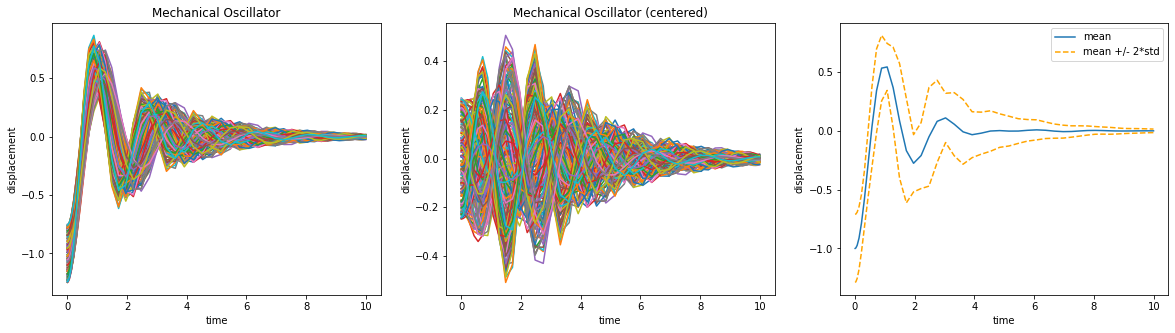

In [5]:
n = 20_000 # number of 'instances'/'realisations'

t = quad_points # row vector
T = np.tile(t, (n, 1)) # repeat row 't' along axis 0

SampleSpace = mech_oscillator_samples(n) # generate samples

Y = mech_oscillator(SampleSpace, T) # compute output (displacement) [n, N_quad]

Y_mean = np.mean(Y, axis=0) # compute mean for each t_i
Y_std = np.std(Y, axis=0) # compute std for each t_i

# center the process
Y_c = Y-Y_mean

'Plots'
fig, ax = plt.subplots(1, 3, figsize=(20,5))

'Plot 200 realisations of the random process'
for i in np.arange(200):
    ax[0].plot(t,Y[i,:], '-')
ax[0].set_ylabel('displacement')
ax[0].set_xlabel('time')
ax[0].set_title('Mechanical Oscillator')

for i in np.arange(200):
    ax[1].plot(t,Y_c[i,:], '-')
ax[1].set_ylabel('displacement')
ax[1].set_xlabel('time')
ax[1].set_title('Mechanical Oscillator (centered)')

'Plot the mean and 2 stds of random process'
ax[2].plot(t,Y_mean, '-', label = 'mean')
ax[2].plot(t,Y_mean+2*Y_std, '--', color = 'orange', label = 'mean +/- 2*std')
ax[2].plot(t,Y_mean-2*Y_std, '--', color = 'orange')
ax[2].set_ylabel('displacement')
ax[2].set_xlabel('time')
ax[2].legend()

plt.show()

# Karhunen Loeve Expansion

Variance quantified by 10 terms = 0.9999956382565869


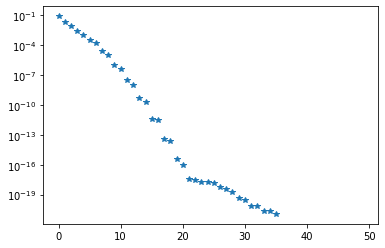

In [6]:
# Covariance matrix
# size: [N_quad, N_quad]
# unbiased estimator: 1/(n-1)
K = (1/(n-1))*np.dot(Y_c.T,Y_c)

# Pre and post multiply covariance matrix with
# square root of quadrature weights
K_new = sqrt_quad_weights @ K @ sqrt_quad_weights

# Eigenvalue Decomposition
eig_values, eig_vectors = np.linalg.eig(K_new)

# Compute true eigenvectors
weighted_eig_vectors = np.linalg.inv(sqrt_quad_weights) @ eig_vectors

# Discard imaginary part, as eigenvalues are real
eig_values = np.real(eig_values)

# Sort eigenvalues in descending order
# reverse sign -> sort in ascending -> reverse sign again
eig_values = -np.sort(-eig_values)

# truncation of KL expansion
n_kl = 10

# variance quantified by a given truncation level: n_kl
r_kl = np.sum(eig_values[:n_kl])/np.sum(eig_values)

print("Variance quantified by", n_kl, "terms =", r_kl)

# plot of eigenvalues
plt.semilogy(eig_values, '*')
plt.show()

In [7]:
# truncate eigenvector space
trunc_eig_vectors = weighted_eig_vectors[:,:n_kl] 

# project f_c (bzw. Y_c) on eigenvectors
# resulting matrix has size [N x n_kl]
# N evaluations for each of the n_kl vectors
Y_i =  Y_c @ quad_weights @ trunc_eig_vectors

# Plot Eigenvectors

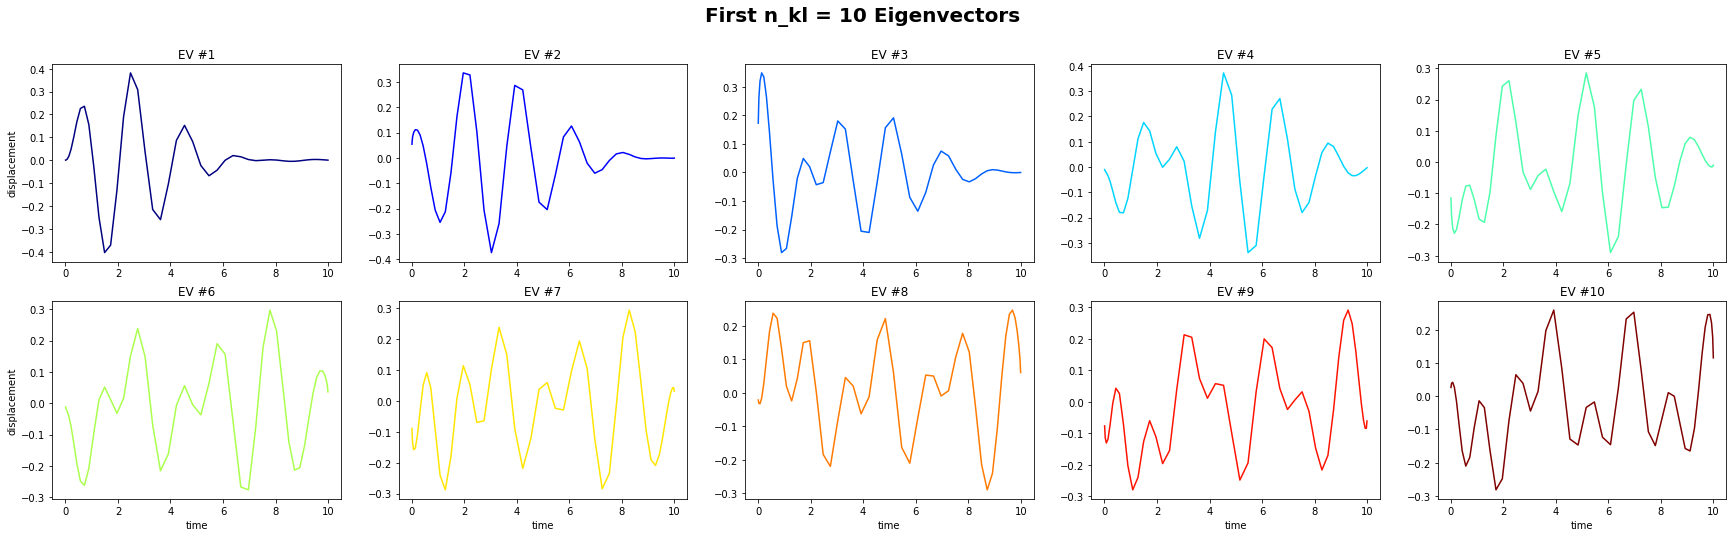

In [8]:
fig, ax = plt.subplots(2, int(n_kl/2), figsize=(3*n_kl, 8))

# change colors in for loop
colors = iter(plt.cm.jet(np.linspace(0,1,n_kl)))

for i in np.arange(n_kl):

    row = int(i//(n_kl/2))
    column = int(i%(n_kl/2))

    ax[row][column].plot(t, np.real(eig_vectors[:,i]), color=next(colors))

    'Formatting'
    if column == 0:
        ax[row][column].set_ylabel('displacement')
    if row == 1:
        ax[row][column].set_xlabel('time')
    
    ax[row][column].set_title('EV #' + str(i+1))

fig.suptitle("First n_kl = " + str(n_kl) + " Eigenvectors", fontsize=20, fontweight= "bold")

plt.show()

# Dot Product

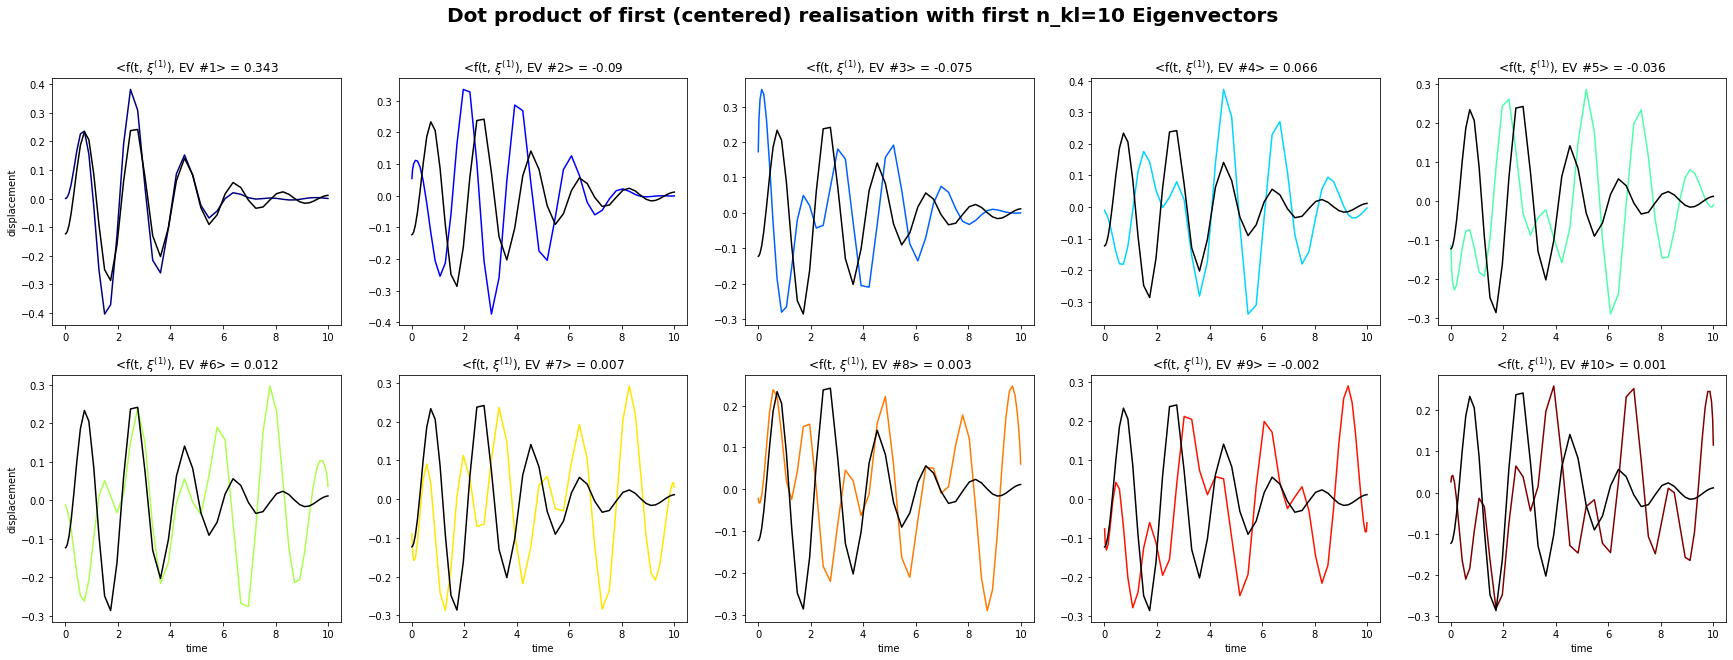

In [9]:
fig, ax = plt.subplots(2, int(n_kl/2), figsize=(3*n_kl, 10))

# change colors in for loop
colors = iter(plt.cm.jet(np.linspace(0,1,n_kl)))

for i in np.arange(n_kl):

    row = int(i//(n_kl/2))
    column = int(i%(n_kl/2))

    ax[row][column].plot(t, np.real(eig_vectors[:,i]), color=next(colors))

    ax[row][column].plot(t, Y_c[0,:], color = 'black')

    'Formatting'
    if column == 0:
        ax[row][column].set_ylabel('displacement')
    if row == 1:
        ax[row][column].set_xlabel('time')
    
    dot_prod_i = np.around(np.real(Y_i[0,i]), 3)

    ax[row][column].set_title(r'<f(t, $\xi^{(1)}$), EV #' + str(i+1) + '> = ' + str(dot_prod_i))

fig.suptitle("Dot product of first (centered) realisation with first n_kl=" + str(n_kl) + " Eigenvectors", fontsize=20, fontweight= "bold")

plt.show()

# Note that the dot product is monotonically decreasing!

# Coefficients of projections

Plot of dot products of each (centered) realisation with each eigenvector

We note that the dot product is monotonically decreasing. This is expected as the projection against the EV with smaller EW
is less important 


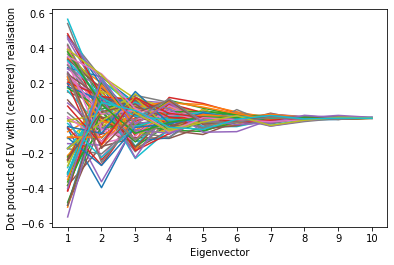

In [10]:

plt.plot(np.arange(1, n_kl+1), np.real(Y_i[:100]).T)
plt.xticks(np.arange(1, n_kl+1, step=1))  # Set label locations.
plt.xlabel('Eigenvector')
plt.ylabel('Dot product of EV with (centered) realisation')
plt.show()

# Truncated Eigenmodes

In [11]:
class KLE_PCE_surrogate(PCE.PCE_surrogate):
    
    # Inherit from class PCE_surrogate from PolynomialChaosExpansion module
    
    '''
    Inputs:
    
        SampleSpace : Samples of random variables [N, N_p]
        
        n_kl : truncation level of KL-expansion
        
        n : total polynomial order
        
        func_vals : evaluated values of eigen_modes 
                    using which surrogate must be constructed [N x n_kl]
        
        eig_values : eigenvalues of the covariance operator
        
    
    Outputs:
    
        Generalised Sobol indices : [N_p, 1]
                                    history-aware index @ t = T of all random variables
    
    '''
    
    
    def __init__(self, SampleSpace, func_evals, total_polynomial_order, n_kl, eig_values, polynomial_classes_of_random_variables,  isoprob_transform):
        
        self.X = SampleSpace
        self.func_evals = func_evals
        self.eig_values = eig_values
        self.n_kl = n_kl
        self.n = total_polynomial_degree
        self.pcrv = polynomial_classes_of_random_variables
        self.N_p = len(self.pcrv)
        self.isoprob_transform = isoprob_transform

        # set classes of random variables
        for i in range(self.N_p):
            
            if self.pcrv[i] == 'Hermite':
                self.pcrv[i] = PCE.Hermite

            if self.pcrv[i] == 'Legendre':
                self.pcrv[i] = PCE.Legendre
        
        #total number of polynomial terms in the PCE
        self.number_of_PCE_terms = int (factorial(self.N_p+self.n) / ( factorial(self.N_p) * factorial(self.n) ))
        
        # compute all permutations of monomials which have total degree <= n
        self.all_permutations, self.comb_dict = PCE.compute_all_permutations(self.n, self.N_p)

    
    def generalised_Sobol(self):

        # coefficient pickers for first and total order index 
        first_order_picker, total_order_picker = self.coefficient_pickers()

        # store coefficients of polynomial surrogates for all eigenmodes
        # each column contains polynomial coefficients corresponding to each eigenmode
        # size = [number_of_PCE_terms, number of eigenmodes]
        store_beta = np.zeros((self.number_of_PCE_terms, self.n_kl))

        # compute coefficients of polynomial surrogates (beta) vector for each eigenmode (f_i)
        # f_i (bzw. Y_i) = projection of f (bzw. Y) on eig_vector_i
        for i in range(self.n_kl):

            store_beta[:,i] = self.find_coefficients(self.X, self.func_evals[:,i])
        
        # sum of squares of coefficients of eigenmodes for a given random varible
        # size [N_p, 1]
        G_first_numerator = np.sum(first_order_picker @ (store_beta**2), axis = 1)
        G_total_numerator = np.sum(total_order_picker @ (store_beta**2), axis = 1)

        # sum of eigenvalues for total variance
        # size [N_p, 1]
        G_denominator = np.sum(self.eig_values[:self.n_kl])

        # first order generalised Sobol index
        # size [N_p, 1]
        self.G_first = G_first_numerator/G_denominator

        # total generalised Sobol index
        # size [N_p, 1]
        self.G_tot = G_total_numerator/G_denominator
        
        'Plots'
        fig, ax = plt.subplots(1, 2, figsize=(15,5))

        'Histogram of general total Sobol indices at t=T'
        params = ['alpha=' + str(np.around(self.G_tot[0], 4)), 
                  'beta='  + str(np.around(self.G_tot[1], 4)), 
                   'l='    + str(np.around(self.G_tot[2], 4))]

        ax[0].bar(params, self.G_tot)
        ax[0].set_xlabel('Parameters')
        ax[0].set_ylabel('Total General Sobol indices')

        'Histogram of first order general Sobol indices at t=T'
        params = ['alpha=' + str(np.around(self.G_first[0], 4)), 
                  'beta='  + str(np.around(self.G_first[1], 4)), 
                   'l='    + str(np.around(self.G_first[2], 4))]

        ax[1].bar(params, self.G_tot)
        ax[1].set_xlabel('Parameters')
        ax[1].set_ylabel('First order General Sobol indices')

        plt.show()

# Compute Generalised Sobol Indices

In [12]:
total_polynomial_degree = 10
polynomial_classes_of_random_variables = ['Legendre', 'Legendre', 'Legendre']

KLE_modes_PCE = KLE_PCE_surrogate(  SampleSpace, Y_i, total_polynomial_degree, n_kl, eig_values, 
                                    polynomial_classes_of_random_variables, 
                                    mech_oscillator_isoprob_transform)

KLE_modes_PCE.generalised_Sobol()

/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
